#  Assignment 7: Multi-Class Model Selection using ROC and Precision-Recall Curves
In this assignment, I explored the problem of **multi-class land cover classification** using the **UCI Landsat Satellite dataset**. The task involved training and evaluating six diverse classifiers: **KNN, Decision Tree, Dummy (Prior), Logistic Regression, Gaussian Naive Bayes, and SVC** on standardized data. Performance was assessed using metrics such as Overall Accuracy, Weighted F1-Score, **ROC-AUC**, and **Precision-Recall (PRC) curves** under a One-vs-Rest (OvR) framework. The analysis focused on interpreting ROC and PRC plots to understand model behavior across varying thresholds and to perform data-driven model selection in a complex multi-class setting.

## Part A: Data Preparation and Baseline

**Importing necessary libraries**

We start by importing the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Random state for reproducibility
RANDOM_STATE = 42

### 1. Load and Prepare Data:

We load the data into dataframe for further analysis.

In [3]:
train_raw = pd.read_csv('sat.trn', sep=r'\s+', header=None)
test_raw  = pd.read_csv('sat.tst', sep=r'\s+', header=None)

df = pd.concat([train_raw, test_raw], ignore_index=True)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [6]:
df.shape

(6435, 37)

There are 6435 data points 36 features and one target column.
The attributes are numerical, in the range 0 to 255.

Class labels:
- 1	- > red soil
- 2 - >	cotton crop
- 3	- > grey soil
- 4 - >	damp grey soil
- 5	- > soil with vegetation stubble
- 6	- > mixture class (all types present)
- 7	- > very damp grey soil

In [7]:
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
dtype: int64

There are no null values so we can move to further analysis.

In [8]:
X = df.iloc[:, :-1].astype(float)
y = df.iloc[:, -1].astype(int)

In [9]:
class_counts = y.value_counts().sort_index()
print("Class distribution (original):\n", class_counts)

Class distribution (original):
 36
1    1533
2     703
3    1358
4     626
5     707
7    1508
Name: count, dtype: int64


We can see that there are no rows present with all classes present (label=6). So we can go for further analysis.

In [10]:
classes = np.unique(y)
print("\nFinal classes:", classes)


Final classes: [1 2 3 4 5 7]


### 2. Train/Test Split and Standarization:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
print("Shapes:", X_train_scaled.shape, X_test_scaled.shape)

Shapes: (4504, 36) (1931, 36)


We have 4504 datapoints in train set and 1931 datapoints in test set.

### 3. Train All Models: 
We are training one instance of six specified model classes on the training data.

In [13]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Dummy (Prior)": DummyClassifier(strategy="prior", random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class="ovr"),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE) 
}

# Train all models
fitted_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    fitted_models[name] = model

### 4. Baseline Evaluation: 

In [14]:
baseline_results = []
for name, model in fitted_models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    wf1 = f1_score(y_test, y_pred, average="weighted")
    baseline_results.append((name, acc, wf1))

baseline_df = pd.DataFrame(baseline_results, columns=["Model", "Accuracy", "Weighted_F1"]).sort_values("Weighted_F1", ascending=False)
baseline_df

,Model,Accuracy,Weighted_F1
0,KNN,0.912481,0.911477
5,SVC,0.897462,0.895996
1,DecisionTree,0.836354,0.837073
3,LogisticRegression,0.838426,0.811937
4,GaussianNB,0.793371,0.800111
2,Dummy (Prior),0.238219,0.091661


We can observe that:
- **KNN** performs best, followed closely by **SVC**, showing these models handle the complex feature space effectively.
- **Decision Tree** and **Logistic Regression** perform moderately, while **Gaussian NB** is slightly weaker due to its **conditional independence assumption**.
- The **Dummy Classifier** serves as the baseline with poor accuracy, confirming that feature-based models add significant predictive value.

## Part B: ROC Analysis for Model Selection

### 1. Multi-Class ROC Calculation:

**How One-vs-Rest is used for multi-class ROC**

- **ROC** (Receiver Operating Characteristic) is defined for binary classifiers: it plots True Positive Rate (TPR) vs False Positive Rate (FPR) as the classification threshold varies.
- For multi-class problems we convert the problem into multiple binary problems using **One-vs-Rest (OvR)**: for each class c, consider that class as “positive” and all other classes as “negative” then compute the ROC curve and AUC for that binary problem.
- We then aggregate these per-class ROC measures into a macro-average (simple mean of per-class AUCs) or a weighted-average (weighted by class support). Macro-average treats each class equally; weighted averages account for class sizes.
- For plotting a single ROC per model we can either show per-class curves OR compute a macro-averaged ROC by interpolating TPR values over a common FPR grid and averaging.

### 2. Plotting ROC:

**Preparing Labels for Multiclass ROC/PRC (One-vs-Rest)**

We first convert class labels into a **binarized (one-hot)** format required for plotting multiclass **ROC** and **Precision-Recall** curves.
Even though the labels are numeric, we remap them to a 0-based contiguous range (0…n_classes−1) to ensure compatibility with label_binarize() and avoid issues if class values are non-continuous (here [1, 2, 3, 4, 5, 7]).

In [15]:
unique_classes = np.sort(np.unique(y_train))
# Map to 0..n_classes-1 for binarize convenience 
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
inv_mapping = {v: k for k, v in class_mapping.items()}

y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Binarize
n_classes = len(unique_classes)
y_test_binarized = label_binarize(y_test_mapped, classes=np.arange(n_classes))
y_train_binarized = label_binarize(y_train_mapped, classes=np.arange(n_classes))

print("Number of classes for OvR:", n_classes)

Number of classes for OvR: 6


**Function to compute per-class ROC and macro-average curve for plotting**

In [16]:
def compute_roc_for_model(model, X_test, y_test_bin, n_classes):
    """
    Returns dict with per-class (fpr, tpr, auc) and macro-avg (fpr_grid, tpr_macro, auc_macro)
    """
    # get probability estimates for each class in mapped 0..n_classes-1
    if hasattr(model, "predict_proba"):
        probas = model.predict_proba(X_test)  # shape (n_samples, n_classes)
    else:
        dec = model.decision_function(X_test)
        probas = dec

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # macro-average by interpolating all tpr on a common FPR grid
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = np.mean([roc_auc[i] for i in range(n_classes)])  # simple macro mean of AUCs
    return {"fpr": fpr, "tpr": tpr, "roc_auc": roc_auc, "all_fpr": all_fpr, "mean_tpr": mean_tpr, "macro_auc": macro_auc}

**Compute ROC info for all models**

In [17]:
roc_results = {}
for name, model in fitted_models.items():
    roc_results[name] = compute_roc_for_model(model, X_test_scaled, y_test_binarized, n_classes)

# Show macro AUC summary
macro_summary = [(name, roc_results[name]["macro_auc"]) for name in roc_results]
pd.DataFrame(macro_summary, columns=["Model", "Macro_AUC"]).sort_values("Macro_AUC", ascending=False)


,Model,Macro_AUC
5,SVC,0.982106
0,KNN,0.980499
3,LogisticRegression,0.956556
4,GaussianNB,0.954065
1,DecisionTree,0.889213
2,Dummy (Prior),0.500000


**Plot OvR ROC curves (macro-average) for all models**

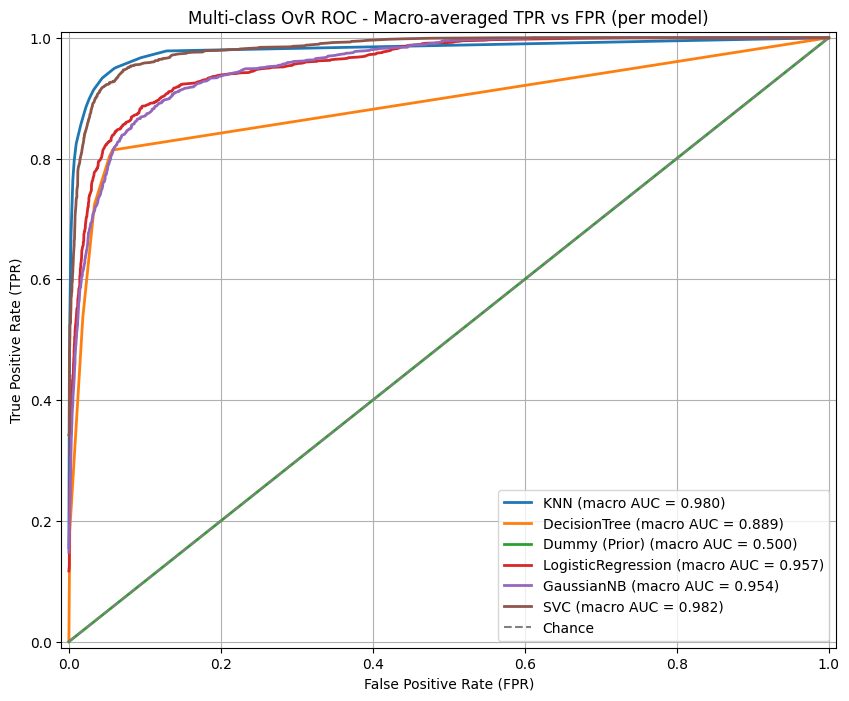

In [18]:
plt.figure(figsize=(10, 8))
for name, res in roc_results.items():
    plt.plot(res["all_fpr"], res["mean_tpr"], lw=2, label=f"{name} (macro AUC = {res['macro_auc']:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Chance")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-class OvR ROC - Macro-averaged TPR vs FPR (per model)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 3. ROC Interpretation:

- The model with the **highest macro-averaged AUC is SVC (0.982)**, showing excellent class separability.

- No model has **AUC < 0.5** — the lowest is the **Dummy (Prior)** model with **AUC = 0.5**, indicating random guessing.
Conceptually, an **AUC < 0.5** means the model performs **worse than random**, ranking negatives higher than positives.
This can happen if class labels are inverted, probabilities are mis-calibrated, or the model systematically confuses the classes.

## Part C: Precision-Recall Curve (PRC) Analysis

### 1. PRC Calculation:

**Why PRC is preferred under class imbalance?**

- The **Precision–Recall Curve (PRC)** is more suitable than the **ROC curve** for imbalanced datasets because it focuses on the **performance of the positive (minority) class.**

- In ROC, the **False Positive Rate (FPR)** is normalized by the large number of negatives, so even many false positives can appear small, making the ROC curve look overly optimistic.

- PRC, on the other hand, plots **Precision** (how many predicted positives are correct) versus **Recall** (how many actual positives are found), directly revealing the trade-off between completeness and correctness of positive predictions.

- Thus, even when imbalance is moderate, **PRC gives a clearer picture of model usefulness on rare or important positive cases**, while ROC may hide poor precision.

### 2. Plotting PRC:

**Function to Compute PRC and Average Precision (AP) for each model**

In [19]:
def compute_prc_for_model(model, X_test, y_test_bin, n_classes):
    
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)
    else:
        scores = model.decision_function(X_test)
        
    precision = dict()
    recall = dict()
    ap = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], scores[:, i])
        ap[i] = average_precision_score(y_test_bin[:, i], scores[:, i])
    # Macro-average precision-recall curve by interpolating precision at common recall points
    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_precision = np.zeros_like(all_recall)
    for i in range(n_classes):
        # interpolation of precision as function of recall (monotonic non-increasing)
        # since precision_recall_curve returns recall in decreasing order, we sort them
        sorted_idx = np.argsort(recall[i])
        r_sorted = recall[i][sorted_idx]
        p_sorted = precision[i][sorted_idx]
        mean_precision += np.interp(all_recall, r_sorted, p_sorted, left=p_sorted[0], right=p_sorted[-1])
    mean_precision /= n_classes
    macro_ap = np.mean([ap[i] for i in range(n_classes)])
    return {"precision": precision, "recall": recall, "ap": ap, "all_recall": all_recall, "mean_precision": mean_precision, "macro_ap": macro_ap}

prc_results = {}
for name, model in fitted_models.items():
    prc_results[name] = compute_prc_for_model(model, X_test_scaled, y_test_binarized, n_classes)

# Summary of macro AP
ap_summary = [(name, prc_results[name]["macro_ap"]) for name in prc_results]
pd.DataFrame(ap_summary, columns=["Model", "Macro_AP"]).sort_values("Macro_AP", ascending=False)

,Model,Macro_AP
0,KNN,0.921878
5,SVC,0.909475
3,LogisticRegression,0.822754
4,GaussianNB,0.802136
1,DecisionTree,0.708667
2,Dummy (Prior),0.166667


**Plot OvR PRC curves (macro-average) for all models**

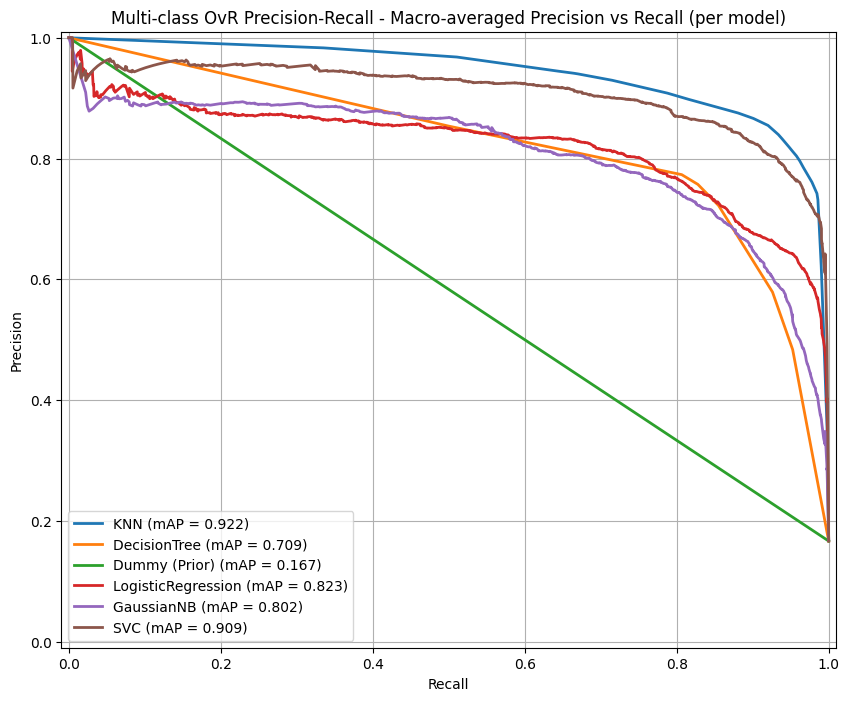

In [20]:
plt.figure(figsize=(10, 8))
for name, res in prc_results.items():
    plt.plot(res["all_recall"], res["mean_precision"], lw=2, label=f"{name} (mAP = {res['macro_ap']:.3f})")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class OvR Precision-Recall - Macro-averaged Precision vs Recall (per model)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

### 3. PRC Interpretation:

- The **K-Nearest Neighbors (KNN)** model achieved the **highest Macro-averaged Average Precision (mAP = 0.922)**, indicating strong precision-recall trade-off and consistent performance across thresholds.
- The **Dummy (Prior)** model performed the worst **(mAP = 0.167)**, with its precision dropping sharply as recall increased.
- Such a steep decline occurs because poor models make many **false positives** as they attempt to capture more positives, causing precision to collapse when recall rises.
- Overall, models like **KNN and SVC** maintain high precision even at high recall levels, reflecting good calibration and discriminative ability.

## Part D: Final Recommendation

### 1. Synthesis: 

We collect ranking tables (Weighted F1, Macro AUC, Macro AP) side-by-side for comparison.
Recompute weighted F1 from earlier for robustness.

In [21]:
wf1_list = []
for name, model in fitted_models.items():
    y_pred = model.predict(X_test_scaled)
    wf1 = f1_score(y_test, y_pred, average="weighted")
    wf1_list.append((name, wf1))

metrics_df = pd.DataFrame({
    "Model": [m for m,_ in wf1_list],
    "Weighted_F1": [v for _,v in wf1_list],
    "Macro_AUC": [roc_results[m]["macro_auc"] for m,_ in wf1_list],
    "Macro_AP": [prc_results[m]["macro_ap"] for m,_ in wf1_list]
}).set_index("Model")

metrics_df = metrics_df.sort_values("Weighted_F1", ascending=False)
metrics_df

,Weighted_F1,Macro_AUC,Macro_AP
Model,,,
KNN,0.911477,0.980499,0.921878
SVC,0.895996,0.982106,0.909475
DecisionTree,0.837073,0.889213,0.708667
LogisticRegression,0.811937,0.956556,0.822754
GaussianNB,0.800111,0.954065,0.802136
Dummy (Prior),0.091661,0.500000,0.166667


The model rankings from the three metrics show broad agreement but with some variations.

- **KNN and SVC** consistently rank at the top across F1, ROC-AUC, and PRC-AP, indicating robust and well-calibrated performance.

- **Logistic Regression** performs slightly lower in F1 and PRC despite having a high AUC, showing that a strong ROC-AUC doesn’t always translate to high precision at practical recall levels.

- **Decision Tree and GaussianNB** show moderate results, while the **Dummy (Prior)** baseline performs worst on all metrics (AUC = 0.5).This highlights the **trade-off between global separability (ROC-AUC) and actual class-wise prediction quality (PRC and F1)**.

### 2. Recommendation:

- Based on all metrics and curve behavior, **KNN** is the best model for this task.
It achieves the highest **Weighted F1 (0.911)** and **Macro-AP (0.922)**, with an excellent **AUC (0.980)**-indicating balanced precision and recall across classes and stable performance across thresholds.
- **SVC** is a close second, showing similar AUC but slightly lower PRC and F1.

Therefore, **KNN** is recommended as the final model for land-cover classification due to its strong overall discriminative ability and reliability across evaluation perspectives.

## Brownie Points Task

### 1. Extra experiments - RandomForest and XGBoost

In [22]:
from sklearn.preprocessing import LabelEncoder, label_binarize

# Encode labels consistently
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
n_classes = len(le.classes_)

# Binarize test labels for ROC/PRC
y_test_binarized = label_binarize(y_test_enc, classes=range(n_classes))

extra_models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=RANDOM_STATE)
}

# Fit models
fitted_models = {}
for name, m in extra_models.items():
    m.fit(X_train_scaled, y_train_enc)
    fitted_models[name] = m

# Compute metrics
roc_results, prc_results = {}, {}
for name in fitted_models:
    roc_results[name] = compute_roc_for_model(fitted_models[name], X_test_scaled, y_test_binarized, n_classes)
    prc_results[name] = compute_prc_for_model(fitted_models[name], X_test_scaled, y_test_binarized, n_classes)

# Summary table
rows = []
for name in fitted_models:
    wf1 = f1_score(y_test_enc, fitted_models[name].predict(X_test_scaled), average="weighted")
    auc_macro = roc_results[name]["macro_auc"]
    ap_macro = prc_results[name]["macro_ap"]
    rows.append((name, wf1, auc_macro, ap_macro))

metrics_df = pd.DataFrame(rows, columns=["Model", "Weighted_F1", "Macro_AUC", "Macro_AP"]).sort_values("Weighted_F1", ascending=False)
metrics_df

,Model,Weighted_F1,Macro_AUC,Macro_AP
1,XGBoost,0.915578,0.990107,0.950879
0,RandomForest,0.913761,0.988584,0.942316


We can observe that both ensemble models **(XGBoost and RandomForest) achieve very high AUCs(0.99)** due to their ability to **capture complex feature interactions** and **handle non-linear decision boundaries** effectively.

### 2. Model with AUC < 0.5
To deliberately obtain a model performing worse than random, I experimented with a "Flipped Prediction" Logistic Regression model.

In [24]:
lr_flip = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr_flip.fit(X_train, y_train)

# Flip the predicted probabilities
y_proba_flip = 1 - lr_flip.predict_proba(X_test)

# Evaluate using the flipped probabilities
from sklearn.metrics import roc_auc_score

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
auc_flip = roc_auc_score(y_test_bin, y_proba_flip, average="macro")
print("Flipped Logistic Regression Macro-AUC:", auc_flip)

Flipped Logistic Regression Macro-AUC: 0.04721968835396891


This produces an **AUC < 0.5 (0.047)**, since **flipping the predicted probabilities inverts the model’s decision confidence**, it ranks incorrect classes higher than correct ones.

Conceptually, this simulates a model that has learned the wrong mapping between features and labels (due to label inversion, data corruption, or overfitting with reversed patterns).